In [1]:
from functools import reduce
from itertools import islice
import math
import pickle

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# from hyperspherical_vae.distributions import VonMisesFisher, HypersphericalUniform

%matplotlib inline

In [2]:
import pyspark
sc = pyspark.SparkContext('local[*]')
spark = pyspark.sql.SparkSession(sc)

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-2.95910589, -2.82438468, -2.68966346, -2.55494224, -2.42022102,
        -2.28549981, -2.15077859, -2.01605737, -1.88133616, -1.74661494,
        -1.61189372, -1.47717251, -1.34245129, -1.20773007, -1.07300885,
        -0.93828764, -0.80356642, -0.6688452 , -0.53412399, -0.39940277,
        -0.26468155, -0.12996034,  0.00476088,  0.1394821 ,  0.27420332,
         0.40892453,  0.54364575,  0.67836697,  0.81308818,  0.9478094 ,
         1.08253062,  1.21725183,  1.35197305,  1.48669427,  1.62141549,
         1.7561367 ,  1.89085792,  2.02557914,  2.16030035,  2.29502157,
         2.42974279,  2.564464  ,  2.69918522,  2.83390644,  2.96862766,
         3.10334887,  3.23807009,  3.37279131,  3.50751252,  3.64223374,
         3.77695496])

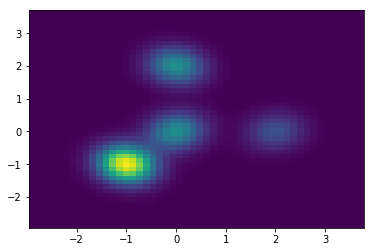

In [3]:
def shuffle(*dfs):
  dataset = reduce(lambda a,b: np.append(a, b, axis=0), dfs)
  permutation = np.random.permutation(dataset.shape[0])
  shuffled = dataset[permutation]
  return shuffled


unit = 0.15

on = unit * 0.1
off = unit * 0.00


def generate_cluster(unit, cross_cov, mu, count):
    mu = np.array(mu)
    sigma_1, sigma_2, sigma_3 = unit, unit, unit
    sigma_1_2, sigma_1_3, sigma_2_3 = cross_cov
    cov = np.array([
      [sigma_1, sigma_1_2, sigma_1_3],
      [sigma_1_2, sigma_2, sigma_2_3],
      [sigma_1_3, sigma_2_3, sigma_3]
    ])
    ds = np.random.multivariate_normal(mu, cov, count)
    return ds


def reduce_correlation(ds, noise):
    count = ds.shape[0]
    ds_t = ds.T
    for i, x in enumerate(noise):
        num = int(count*x)
        ds_t[i].put(np.random.choice(count, num, replace=False), np.random.choice(ds.T[i], num))
    return ds_t.T


rv1 = generate_cluster(unit, (on, -off, off), [2,0,0], 250000) 
rv2 = generate_cluster(unit, (on, off, -off), [0,0,2], 500000)
rv3 = generate_cluster(unit, (-on, off, off), [0,2,0], 500000)
rv4 = generate_cluster(unit, (-on, -off, -off), [-1,-1,-1], 1000000)

# rv5 = generate_cluster(unit, (on, -off, off), [0,0,2], 1250000)
# rv6 = generate_cluster(unit, (-on, off, -off), [0,2,0], 1000000)
# 
# data = np.append(shuffle(rv1, rv2, rv3, rv4), shuffle(rv5, rv6), axis=1)

data = reduce(lambda a,b: np.append(a, b, axis=0), [rv1, rv2, rv3, rv4])

# ind_var = np.random.uniform(-1, 1, [data.shape[0], 20])

# data = np.append(data, ind_var, axis=1)

data = shuffle(data)

# data = reduce_correlation(data, [0.75, 0.75, 0.75])
plt.hist2d(data[:, 0], data[:, 1], bins=50)

In [4]:
class VariationalAutoEncoder(object):
    def __init__(self, n_input_units, n_hidden_layers, n_hidden_units, n_latent_units,
                 learning_rate=0.005, batch_size=100, min_beta=1.0, max_beta=1.0,
                 distribution='normal', serial_layering=None):
        self.n_input_units = n_input_units
        self.n_hidden_layers = n_hidden_layers
        self.n_hidden_units = n_hidden_units
        self.n_latent_units = n_latent_units
        self.learning_rate = learning_rate
        self.batch_size = int(batch_size)
        self.min_beta = min_beta
        self.max_beta = max_beta
        self.distribution = distribution
        self.serial_layering = serial_layering or [self.n_hidden_layers]
        if serial_layering:
            if not isinstance(serial_layering, (list, tuple)):
                raise TypeError("Argument 'serial_layering' must be a list or tuple of integers.")
            elif not all([isinstance(x, int) for x in serial_layering]):
                raise TypeError("Argument 'serial_layering' must be a list or tuple of integers.")
            elif sum(serial_layering) != self.n_hidden_layers:
                raise ValueError("Groupings in 'serial_layering' must sum to 'n_hidden_layers'.")

    class Encoder(object):
        def __init__(self, n_hidden_layers, n_hidden_units, n_latent_units, distribution, serial_layering=None):
            self.n_hidden_layers = n_hidden_layers
            self.n_hidden_units = n_hidden_units
            self.n_latent_units = n_latent_units
            self.distribution = distribution
            self.serial_layering = serial_layering or [self.n_hidden_layers]

        def init_hidden_layers(self):
            self.hidden_layers = []
            self.applied_hidden_layers = []
            self.mu_list = []
            self.applied_mu_list = []
            self.sigma_list = []
            self.applied_sigma_list = []

        def add_hidden_layer(self, inputs, initializer=None):
            self.hidden_layers.append(
                tf.layers.Dense(units=self.n_hidden_units, activation=tf.nn.sigmoid, kernel_initializer=initializer))
            self.applied_hidden_layers.append(self.hidden_layers[-1].apply(inputs))
            return self.applied_hidden_layers[-1]

        def add_mu_and_sigma(self, inputs):
            if self.distribution == 'normal':
                mu = tf.layers.Dense(units=self.n_latent_units)
                applied_mu = mu.apply(inputs)
                sigma = tf.layers.Dense(units=self.n_latent_units)
                applied_sigma = sigma.apply(inputs)
            elif self.distribution == 'vmf':
                mu = tf.layers.Dense(units=self.n_latent_units + 1,
                                     activation=lambda x: tf.nn.l2_normalize(x, axis=-1))
                applied_mu = mu.apply(inputs)
                sigma = tf.layers.Dense(units=1, activation=tf.nn.softplus)
                applied_sigma = sigma.apply(inputs) + 1
            else:
                raise NotImplemented

            self.mu_list.append(mu)
            self.applied_mu_list.append(applied_mu)
            self.sigma_list.append(sigma)
            self.applied_sigma_list.append(applied_sigma)

            return self.applied_mu_list[-1], self.applied_sigma_list[-1]

        def build(self, inputs):
            self.init_hidden_layers()

            initializer = None
            layer = inputs
            for group_size in self.serial_layering:
                for i in range(group_size):
                    layer = self.add_hidden_layer(layer, initializer=initializer)
                self.add_mu_and_sigma(layer)

                # initializer = tf.initializers.constant(np.diag(np.ones(self.n_hidden_units)))
                initializer = tf.initializers.identity()

            return self.applied_mu_list, self.applied_sigma_list

        @property
        def mu(self):
            return self.mu_list[-1]

        @property
        def sigma(self):
            return self.sigma_list[-1]

        def eval(self, sess):
            layers = [
                sess.run([l.kernel, l.bias])
                for l in self.hidden_layers
            ]

            mu = sess.run([self.mu.kernel, self.mu.bias])

            sigma = sess.run([self.sigma.kernel, self.sigma.bias])

            return layers, mu, sigma

    class Decoder(object):
        def __init__(self, n_hidden_layers, n_hidden_units, n_output_units, serial_layering=None):
            self.n_hidden_layers = n_hidden_layers
            self.n_hidden_units = n_hidden_units
            self.n_output_units = n_output_units
            self.serial_layering = serial_layering or [self.n_hidden_layers]

        def init_hidden_layers(self):
            self.hidden_layers = []
            self.applied_hidden_layers = []
            self.output_list = []
            self.applied_output_list = []

        def add_hidden_layer(self, inputs, initializer=None):
            self.hidden_layers.append(
                tf.layers.Dense(units=self.n_hidden_units, activation=tf.nn.sigmoid, kernel_initializer=initializer))
            self.applied_hidden_layers.append(self.hidden_layers[-1].apply(inputs))
            return self.applied_hidden_layers[-1]

        def add_output(self, inputs):
            output = tf.layers.Dense(units=self.n_output_units)
            applied_output = output.apply(inputs)
            self.output_list.append(output)
            self.applied_output_list.append(applied_output)
            return applied_output

        def build(self, inputs_list):
            if len(inputs_list) != len(self.serial_layering):
                raise ValueError("Number of inputs ({}) must equal number of serial layering groups ({})."
                                 .format(len(inputs_list), len(self.serial_layering)))

            self.init_hidden_layers()

            initializer = None
            for group_size, inputs in zip(self.serial_layering, inputs_list):
                layer = inputs
                for i in range(group_size):
                    layer = self.add_hidden_layer(layer, initializer=initializer)
                self.add_output(layer)

                # initializer = tf.initializers.constant(np.diag(np.ones(self.n_hidden_units)))
                initializer = tf.initializers.identity()

            return self.applied_output_list

        @property
        def output(self):
            return self.output_list[-1]

        def eval(self, sess):
            layers = [
                sess.run([l.kernel, l.bias])
                for l in self.hidden_layers
            ]

            output = sess.run([self.output.kernel, self.output.bias])

            return layers, output

    def sampled_z(self, mu, sigma, batch_size):
        if self.distribution == 'normal':
            epsilon = tf.random_normal(tf.stack([int(batch_size), self.n_latent_units]))
            z = mu + tf.multiply(epsilon, tf.exp(0.5 * sigma))
            loss = tf.reduce_mean(-0.5 * self.beta * tf.reduce_sum(1.0 + sigma - tf.square(mu) - tf.exp(sigma), 1))
        elif self.distribution == 'vmf':
            self.q_z = VonMisesFisher(mu, sigma, validate_args=True, allow_nan_stats=False)
            z = self.q_z.sample()
            self.p_z = HypersphericalUniform(self.n_latent_units, validate_args=True, allow_nan_stats=False)
            loss = tf.reduce_mean(-self.q_z.kl_divergence(self.p_z))
        else:
            raise NotImplemented

        return z, loss

    def build_feature_loss(self, x, output):
        return tf.reduce_mean(tf.reduce_sum(tf.squared_difference(x, output), 1))

    def initialize_tensors(self):
        self.x = tf.placeholder("float32", [self.batch_size, self.n_input_units])
        self.beta = tf.placeholder("float32", [1, 1])
        self.encoder = self.Encoder(self.n_hidden_layers, self.n_hidden_units, self.n_latent_units,
                                    self.distribution, self.serial_layering)
        mu_list, sigma_list = self.encoder.build(self.x)
        self.mu_list = mu_list
        self.sigma_list = sigma_list

        self.z_list = []
        self.latent_loss_list = []
        for mu, sigma in zip(self.mu_list, self.sigma_list):
            z, latent_loss = self.sampled_z(mu, sigma, self.batch_size)
            self.z_list.append(z)
            self.latent_loss_list.append(latent_loss)

        self.decoder = self.Decoder(self.n_hidden_layers, self.n_hidden_units, self.n_input_units, self.serial_layering)
        self.output_list = self.decoder.build(self.z_list)

        self.feature_loss_list = [self.build_feature_loss(self.x, output) for output in self.output_list]
        self.loss_list = [feature_loss + latent_loss for feature_loss, latent_loss in
                          zip(self.feature_loss_list, self.latent_loss_list)]

    def total_steps(self, data_count, epochs):
        num_batches = int(data_count / self.batch_size)
        return (num_batches * epochs) - epochs

    def generate_beta_values(self, data_count, epochs):
        total_steps = self.total_steps(data_count, epochs)
        beta_delta = self.max_beta - self.min_beta
        log_beta_step = 5 / float(total_steps)
        return [
            self.min_beta + (beta_delta * (1 - math.exp(-5 + (i * log_beta_step))))
            for i in range(total_steps)
        ]

    def generate_optimizers(self, data_count, epochs):
        total_steps = self.total_steps(data_count, epochs)
        num_groups = len(self.feature_loss_list)
        group_steps = int(total_steps / num_groups)

        optimizers = [
            (tf.train.AdamOptimizer(self.learning_rate).minimize(feature_loss + latent_loss), feature_loss, latent_loss)
            for feature_loss, latent_loss in zip(self.feature_loss_list, self.latent_loss_list)
        ]

        optimizer_indices = [
            min(num_groups - 1, int(i / group_steps))
            for i in range(total_steps)
        ]

        return optimizers, optimizer_indices

    def train_from_rdd(self, data_rdd, epochs=1):
        self.initialize_tensors()

        data_count = data_rdd.count()
        beta_values = self.generate_beta_values(data_count, epochs)
        optimizers, optimizer_indices = self.generate_optimizers(data_count, epochs)

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())

            for epoch_index in range(epochs):
                iterator = data_rdd.toLocalIterator()
                batch_index = 0
                while True:
                    batch = np.array(list(islice(iterator, self.batch_size)))
                    if batch.shape[0] == self.batch_size:
                        beta = beta_values.pop(0) if beta_values else self.min_beta
                        optimizer_index = optimizer_indices.pop(0) if optimizer_indices else -1
                        optimizer, feature_loss, latent_loss = optimizers[optimizer_index]

                        feed_dict = {self.x: np.array(batch), self.beta: np.array([[beta]])}

                        if not batch_index % 1000:
                            print("beta: {}".format(beta))
                            print("layer group: {}".format(optimizer_index))

                            f_ls, d_ls = sess.run([feature_loss, latent_loss], feed_dict=feed_dict)
                            
                            print("avg_feature_loss={}, avg_latent_loss={}".format(np.mean(f_ls), np.mean(d_ls)))
                            print('running batch {} in epoch {}'.format(batch_index, epoch_index))
                            
                        sess.run(optimizer, feed_dict=feed_dict)
                        batch_index += 1
                    else:
                        print("incomplete batch: {}".format(batch.shape))
                        break

            print("evaluating model...")
            encoder_layers, eval_mu, eval_sigma = self.encoder.eval(sess)
            decoder_layers, eval_output = self.decoder.eval(sess)

        return VariationalAutoEncoderModel(encoder_layers, eval_mu, eval_sigma, decoder_layers, eval_output)

    def train(self, data, visualize=False, epochs=1):
        self.initialize_tensors()

        data_size = data.shape[0]
        batch_size = self.batch_size
        beta_values = self.generate_beta_values(data_size, epochs)

        optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())

            i = 0
            while (i * batch_size) < data_size:
                batch = data[i * batch_size:(i + 1) * batch_size]
                beta = beta_values.pop(0) if len(beta_values) > 0 else self.min_beta
                feed_dict = {self.x: batch, self.beta: np.array([[beta]])}
                sess.run(optimizer, feed_dict=feed_dict)
                if visualize and (not i % int((data_size / batch_size) / 3) or i == int(data_size / batch_size) - 1):
                    ls, d, f_ls, d_ls = sess.run([self.loss, self.output, self.feature_loss, self.latent_loss],
                                                 feed_dict=feed_dict)
                    plt.scatter(batch[:, 0], batch[:, 1])
                    plt.show()
                    plt.scatter(d[:, 0], d[:, 1])
                    plt.show()
                    print(i, ls, np.mean(f_ls), np.mean(d_ls))

                i += 1

            encoder_layers, eval_mu, eval_sigma = self.encoder.eval(sess)
            decoder_layers, eval_output = self.decoder.eval(sess)

        return VariationalAutoEncoderModel(encoder_layers, eval_mu, eval_sigma, decoder_layers, eval_output)


class VariationalAutoEncoderModel(object):
    def __init__(self, encoder_layers, mu, sigma, decoder_layers, output):
        self.encoder = self.EncoderModel(encoder_layers, mu, sigma)
        self.decoder = self.DecoderModel(decoder_layers, output)

    def save(self, path):
        encoder_layers, encoder_mu, encoder_sigma = self.encoder.dump()
        decoder_layers, decoder_output = self.decoder.dump()
        serializable_model = (encoder_layers, encoder_mu, encoder_sigma, decoder_layers, decoder_output)
        pickle.dump(serializable_model, open(path, 'w+'))

    def encode(self, x):
        return self.encoder.encode(x)

    def project(self, x):
        return self.encoder.encode(x)[0]

    def decode(self, x):
        return self.decoder.decode(x)

    @classmethod
    def load(cls, path):
        return cls(*pickle.load(open(path, 'r')))

    class Layer(object):
        def __init__(self, kernel, bias, activation='linear'):
            self.kernel = kernel
            self.bias = bias
            self.activation = activation

        def dump(self):
            return (self.kernel, self.bias, self.activation)

        @property
        def apply_func(self):
            kernel, bias = self.kernel, self.bias

            linear = lambda inputs: np.matmul(inputs, kernel) + bias

            if self.activation == 'linear':
                f = linear
            elif self.activation == 'sigmoid':
                f = lambda inputs: 1 / (1 + np.exp(-linear(inputs)))

            return f

        def apply(self, inputs):
            return self.apply_func(inputs)

    class EncoderModel(object):
        def __init__(self, encoder_layers, mu, sigma):
            self.layers = [
                VariationalAutoEncoderModel.Layer(kernel, bias, 'sigmoid')
                for kernel, bias in encoder_layers
            ]
            self.mu = VariationalAutoEncoderModel.Layer(*mu)
            self.sigma = VariationalAutoEncoderModel.Layer(*sigma)

        def dump(self):
            encoder_layers = [l.dump()[:2] for l in self.layers]
            encoder_mu = self.mu.dump()[:2]
            encoder_sigma = self.sigma.dump()[:2]
            return encoder_layers, encoder_mu, encoder_sigma

        def encode(self, inputs):
            x = inputs
            for l in self.layers:
                x = l.apply(x)
            return self.mu.apply(x), self.sigma.apply(x)

    class DecoderModel(object):
        def __init__(self, decoder_layers, output):
            self.layers = [
                VariationalAutoEncoderModel.Layer(kernel, bias, 'sigmoid')
                for kernel, bias in decoder_layers
            ]
            self.output = VariationalAutoEncoderModel.Layer(*output)

        def dump(self):
            decoder_layers = [l.dump()[:2] for l in self.layers]
            decoder_output = self.output.dump()[:2]
            return decoder_layers, decoder_output

        def decode(self, inputs):
            x = inputs
            for l in self.layers:
                x = l.apply(x)
            return self.output.apply(x)


In [5]:
rdd = sc.parallelize(data)

model = VariationalAutoEncoder(n_input_units=data.shape[1], n_hidden_layers=3, 
                               n_hidden_units=9, n_latent_units=1, 
                               learning_rate=0.005, batch_size=100, 
                               min_beta=0.01, max_beta=1, distribution='normal', serial_layering=[2,1])\
    .train_from_rdd(rdd, epochs=1)

UnboundLocalError: local variable 'inputs' referenced before assignment

In [6]:
# model = VariationalAutoEncoder(n_input_units=data.shape[1], n_hidden_layers=2, 
#                                n_hidden_units=9, n_latent_units=1, 
#                                learning_rate=0.005, batch_size=100, 
#                                min_beta=1, max_beta=1, distribution='vmf')\
#     .train(data, epochs=1, visualize=True)

(array([2.21000e+02, 2.18000e+03, 9.39000e+03, 7.42160e+04, 3.18314e+05,
        3.27378e+05, 1.65921e+05, 6.05690e+04, 2.03770e+04, 8.98500e+03,
        4.43100e+03, 2.56800e+03, 1.56200e+03, 1.03600e+03, 7.06000e+02,
        4.92000e+02, 3.30000e+02, 2.62000e+02, 2.25000e+02, 1.45000e+02,
        1.28000e+02, 1.00000e+02, 7.00000e+01, 7.60000e+01, 4.50000e+01,
        5.20000e+01, 3.90000e+01, 3.40000e+01, 3.50000e+01, 3.40000e+01,
        2.50000e+01, 2.40000e+01, 4.10000e+01, 4.50000e+01, 9.40000e+01,
        1.47000e+02, 2.93000e+02, 5.02000e+02, 9.34000e+02, 1.76700e+03,
        3.12300e+03, 5.81700e+03, 1.09550e+04, 1.89330e+04, 2.67950e+04,
        3.28170e+04, 3.62460e+04, 3.78510e+04, 3.87970e+04, 4.02140e+04,
        4.26260e+04, 4.66300e+04, 5.29790e+04, 5.29080e+04, 2.77050e+04,
        1.15540e+04, 5.17700e+03, 2.43700e+03, 1.24900e+03, 9.59000e+02,
        1.06600e+03, 1.89200e+03, 3.64900e+03, 7.84000e+03, 1.87800e+04,
        5.60940e+04, 9.73400e+04, 5.37610e+04, 9.77

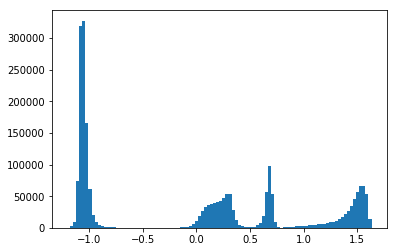

In [9]:
encoded_sample = model.project(data)
plt.hist(encoded_sample, bins=100)

In [8]:
vec_sample = np.array(rdd.sample(False, 0.01).collect())
encoded_sample = model.project(vec_sample)

# decoded_sample = data
decoded_sample = model.decode(encoded_sample)
decoded_sample.shape

(22535, 3)

In [17]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

encoded_x_sample = encoded_sample[:,0].reshape(-1,1)
dencoded_y_sample = decoded_sample[:,0].reshape(-1,1)

for i in range(2, 10):
  z_train, z_test, x_train, x_test = train_test_split(encoded_x_sample, dencoded_y_sample, test_size=0.4)
  gmm = GaussianMixture(i).fit(z_train)
  bic = gmm.bic(z_test)
  labels = gmm.predict(z_test)
  ss = silhouette_score(x_test, labels)
  print(i, bic, ss)

(2, 22860.687369517636, 0.41072610349447514)
(3, 12763.132987421812, 0.4873411057035125)
(4, 9621.984985738864, 0.6049687548656997)
(5, 9496.53577122682, 0.5700197372127715)
(6, 9048.603016026918, 0.37332278940894126)
(7, 8913.499825276993, 0.31950360789236504)
(8, 8888.716481612686, 0.2757845583639317)
(9, 8776.807228609861, 0.30912203993217174)


In [31]:
a = np.append(labels.reshape(-1,1), x_test, axis=1)

In [38]:
np.where()

(array([   0,    0,    1, ..., 9012, 9013, 9013]),
 array([0, 1, 0, ..., 1, 0, 1]))